In [4]:
# import the necessary packages
import torch
import os

IMAGE_TRAIN_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/train"
MASK_TRAIN_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/train_labels"
IMAGE_TEST_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/test"
MASK_TEST_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/test_labels"
IMAGE_VALID_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/val"
MASK_VALID_DATASET_PATH = "/usr/src/app/roads_dataset_cropped/tiff/val_labels"

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [68]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 5
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [69]:
import numpy as np
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [70]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [71]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
            
        if is_train == True:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[:x]
        else:
            x = round(len(os.listdir(input_dir)) * .8)
            self.images = os.listdir(input_dir)[x:]
        for i in range(len(self.images)):
            s = self.images[i]
            if (s[-18] == ".ipynb_checkpoints"):
                self.images.pop(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        mask_path   = mask_path[:-1]
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [72]:
train_transform = A.Compose(
    [
        A.Resize(height=INPUT_IMAGE_HEIGHT, width=INPUT_IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=INPUT_IMAGE_HEIGHT, width=INPUT_IMAGE_WIDTH),
        ToTensorV2(),
    ],
)

In [73]:
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform):
    !rm -rf `find -type d -name .ipynb_checkpoints`
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    return train_loader

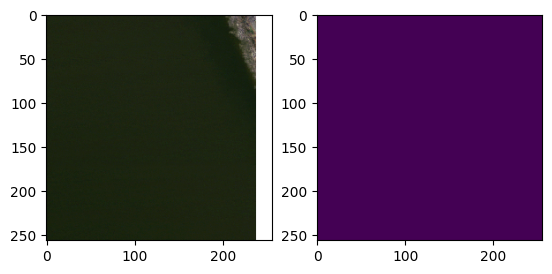

In [74]:
train_loader = get_loaders( IMAGE_TRAIN_DATASET_PATH, MASK_TRAIN_DATASET_PATH,
                            BATCH_SIZE,  train_transform)

val_loader = get_loaders( IMAGE_VALID_DATASET_PATH, MASK_VALID_DATASET_PATH,
                            BATCH_SIZE,  val_transform)

test_loader = get_loaders( IMAGE_TEST_DATASET_PATH, MASK_TEST_DATASET_PATH,
                            BATCH_SIZE,  val_transform)

inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [75]:
def check_accuracy(loader, model, show_pr, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    iou = 0
    iou_micro = 0
    model.eval()
    precision = []
    precision_macro = []
    recall = []
    recall_macro = []

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )
            iou += ((((preds * mask).sum()) / ((preds + mask).sum() - (preds * mask).sum())) + ((((1 - preds) * (1 - mask)).sum()) / (((1 - preds) + (1 - mask)).sum() - ((1 - preds) * (1 - mask)).sum()))) / 2
            iou_micro += (((preds * mask).sum() + ((1 - preds) * (1 - mask)).sum()) / ((preds + mask).sum() + ((1 - preds) + (1 - mask)).sum() - (preds * mask).sum() - ((1 - preds) * (1 - mask)).sum()))
            if (show_pr == 1):
                precision.append(((preds * mask).sum() / (preds).sum()).detach().to('cpu').numpy())
                precision_macro.append(((((preds * mask).sum()) / ((preds).sum()) + (((1 - preds) * (1 - mask)).sum()) / (((1 - preds)).sum())) / 2).detach().to('cpu').numpy())
                recall.append(((preds * mask).sum() / (mask).sum()).detach().to('cpu').numpy())
                recall_macro.append(((((preds * mask).sum()) / ((mask).sum()) + (((1 - preds) * (1 - mask)).sum()) / (((1 - mask)).sum())) / 2).detach().to('cpu').numpy())
            
    if (show_pr == 1):
        for i in range(len(precision_macro)):
            for j in range(i,len(precision_macro)):
                if (recall[j] < recall[i]):
                    swp = recall[j]
                    recall[j] = recall[i]
                    recall[i] = swp
                    swp = precision[j]
                    precision[j] = precision[i]
                    precision[i] = swp
                
                if (recall_macro[j] < recall_macro[i]):
                    swp = recall_macro[j]
                    recall_macro[j] = recall_macro[i]
                    recall_macro[i] = swp
                    swp = precision_macro[j]
                    precision_macro[j] = precision_macro[i]
                    precision_macro[i] = swp
    
        fig, ax = plt.subplots()
        ax.plot(recall_macro, precision_macro, color='purple')

        ax.set_title('Precision-Recall Macro')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        plt.show() 
    
        ig, ax = plt.subplots()
        ax.plot(recall, precision, color='purple')

        ax.set_title('Precision-Recall Micro')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        plt.show() 

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    print(f"IoU score: {iou/len(loader)*100:.2f}")
    print(f"IoU(micro) score: {iou_micro/len(loader)*100:.2f}")
    model.train()

In [76]:
model = smp.Unet(encoder_name='efficientnet-b3', in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)

In [77]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

########################## epoch: 0


100%|██████████| 12/12 [00:03<00:00,  3.88it/s]


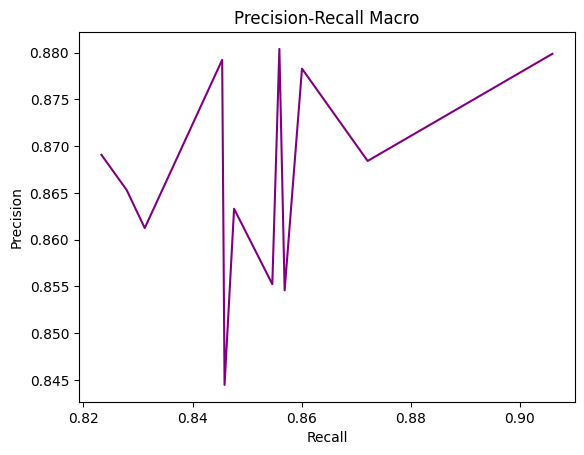

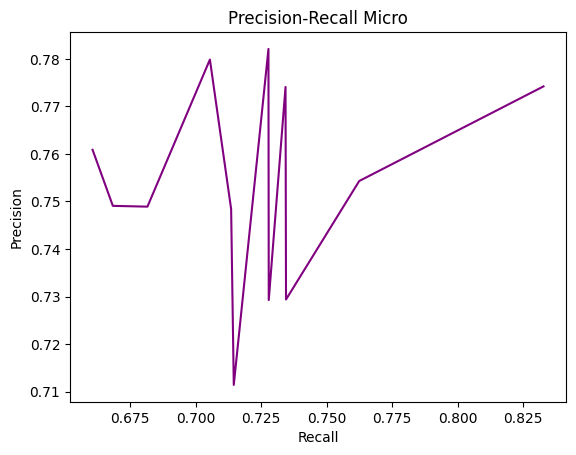

Got 22631258/23461888 with pixel accuracy 96.46
Dice score: 73.67
IoU score: 77.34
IoU(micro) score: 93.20
########################## epoch: 1


100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


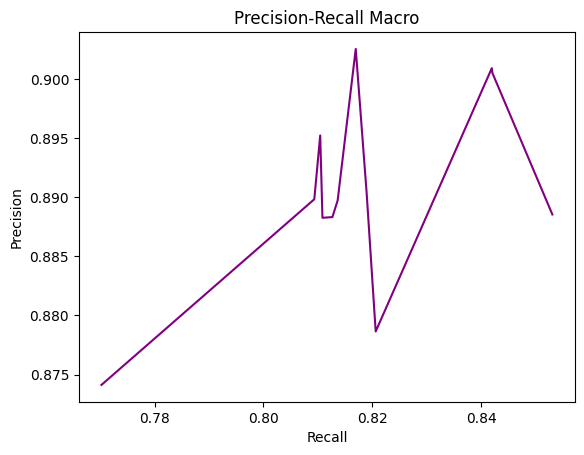

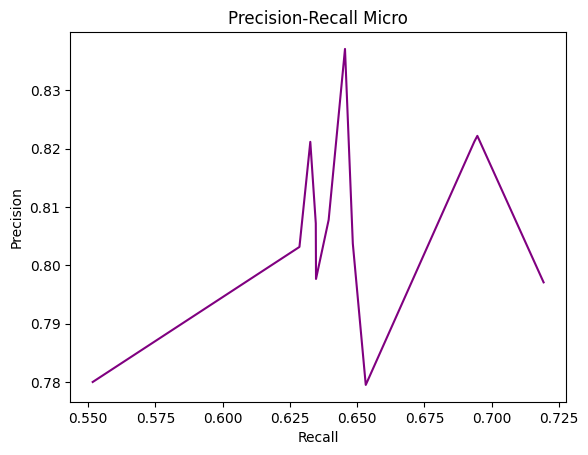

Got 22665994/23461888 with pixel accuracy 96.61
Dice score: 71.80
IoU score: 76.24
IoU(micro) score: 93.36
########################## epoch: 2


100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


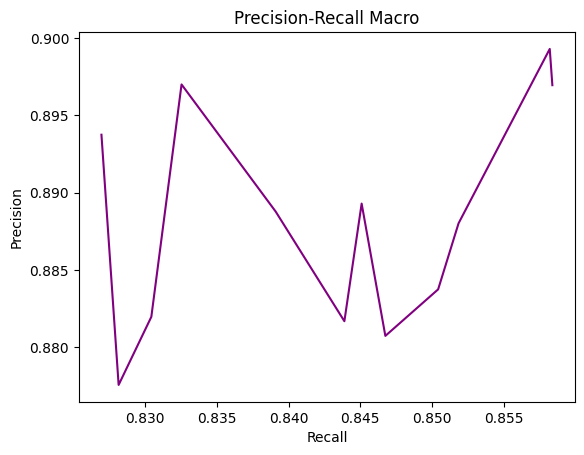

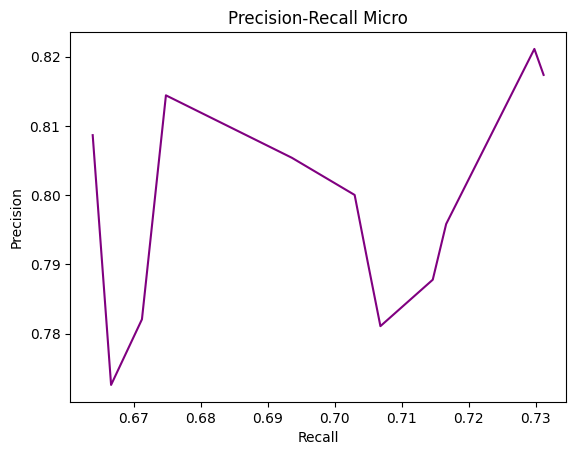

Got 22705514/23461888 with pixel accuracy 96.78
Dice score: 74.46
IoU score: 77.97
IoU(micro) score: 93.76
########################## epoch: 3


100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


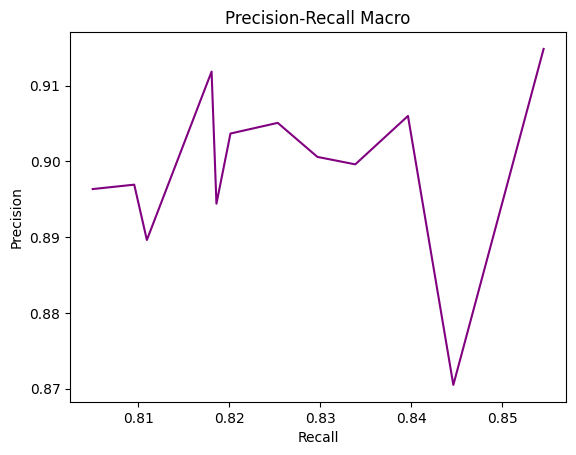

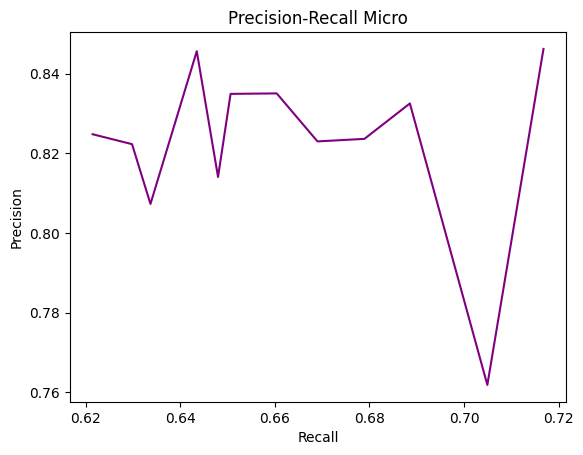

Got 22696051/23461888 with pixel accuracy 96.74
Dice score: 73.32
IoU score: 77.24
IoU(micro) score: 93.66
########################## epoch: 4


100%|██████████| 12/12 [00:03<00:00,  3.87it/s]


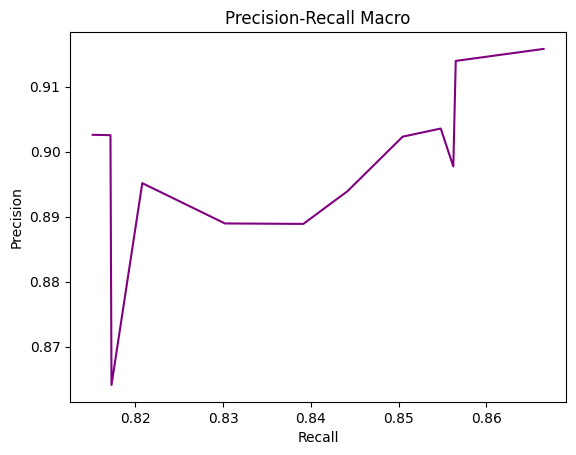

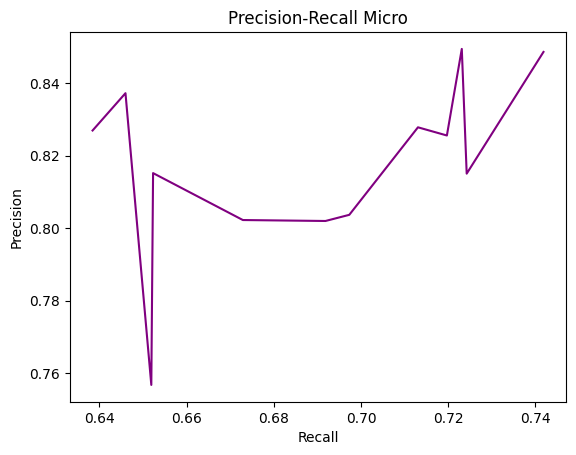

Got 22732624/23461888 with pixel accuracy 96.89
Dice score: 74.76
IoU score: 78.21
IoU(micro) score: 93.83


In [78]:
for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    !rm -rf `find -type d -name .ipynb_checkpoints`
    # check accuracy
    check_accuracy(val_loader, model, 1, device=DEVICE)

100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


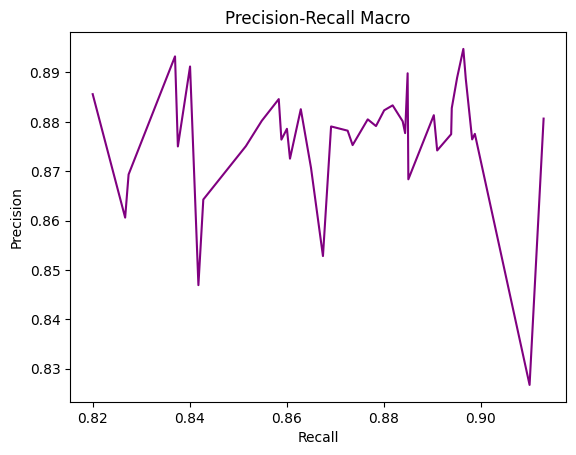

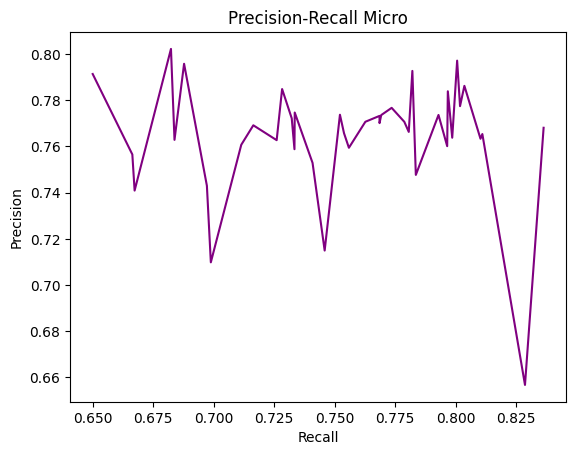

Got 80370374/82116608 with pixel accuracy 97.87
Dice score: 75.77
IoU score: 79.44
IoU(micro) score: 95.88


In [38]:
check_accuracy(test_loader, model, 1, device=DEVICE)

In [67]:
dummy_input = torch.randn(16, 3, 256, 256, device='cuda')

torch.onnx.export(
    model.cuda(),    # PyTorch model
    dummy_input,   # Input data
    "./mymodel.onnx",  # Output file path
    verbose=True,   # Print detailed output
)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



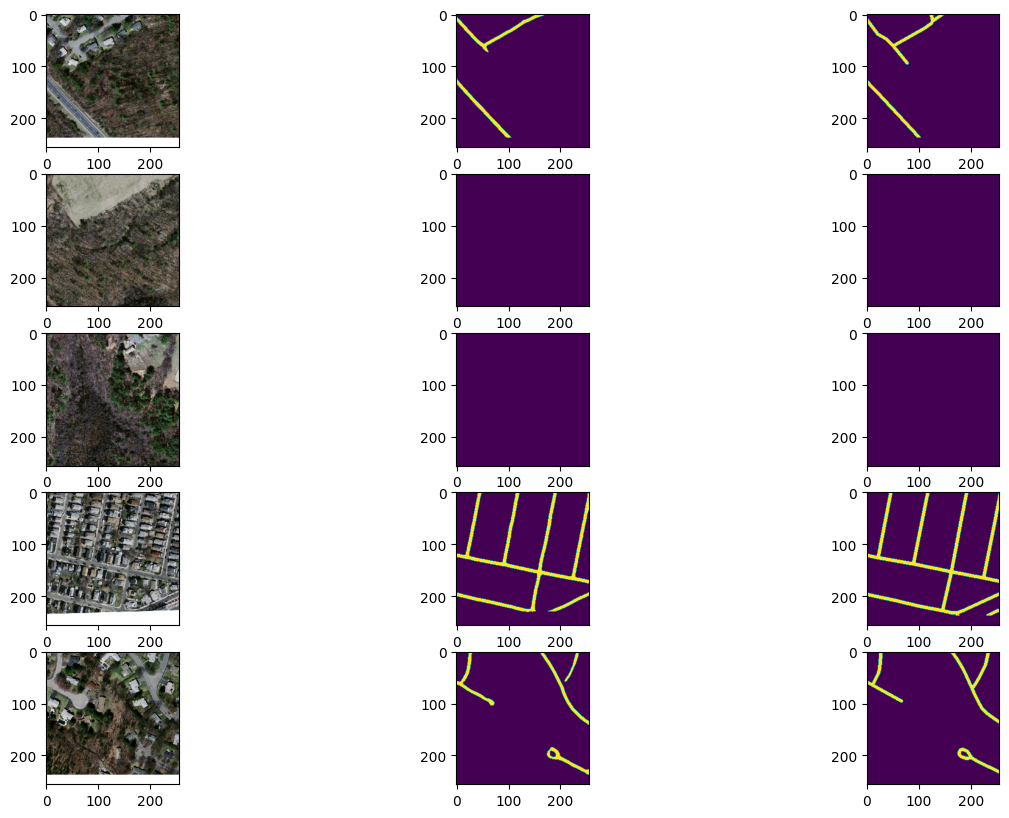

In [80]:
inputs, masks = next(iter(test_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(5,3, figsize=(15,10))
for k in range(5):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])